# VectorDB - Pinecone

In [ ]:
!pip install datasets
!pip install pinecone-client
!pip install sentence-transformers

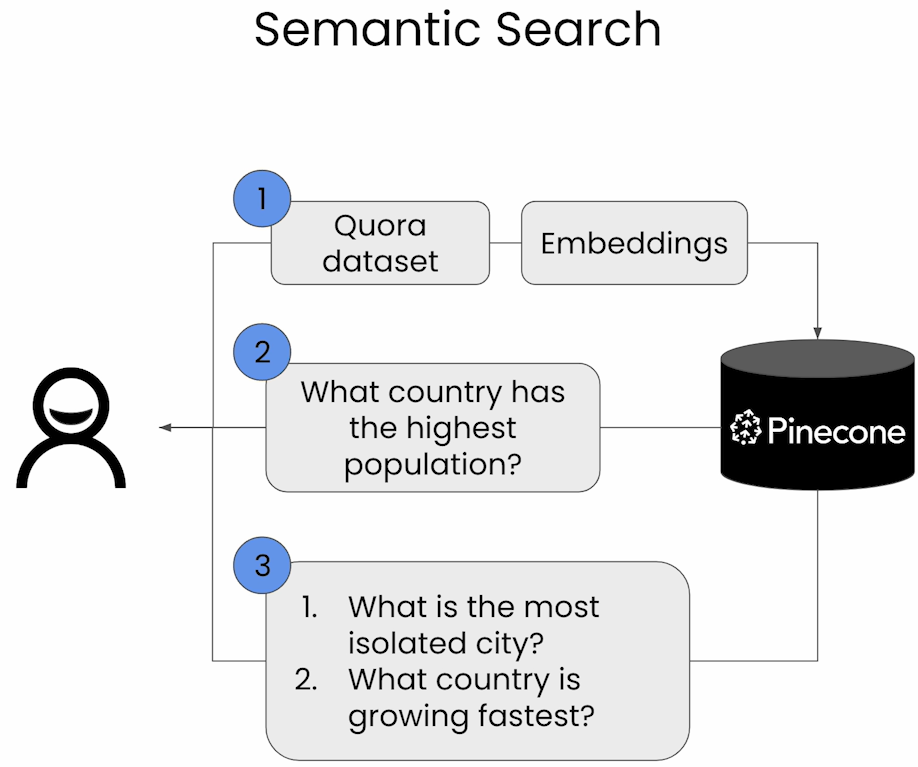

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
# basics
import os
import json
import torch

# progress
from tqdm.auto import tqdm

# API access
from google.colab import userdata

# data & DB
from google.colab import userdata
from datasets import load_dataset
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer

In [ ]:
# lets load quora dataset
dataset = load_dataset("quora", split="train[240000:290000]", trust_remote_code=True)

In [5]:
dataset[0:7]

{'questions': [{'id': [207550, 351729],
   'text': ['What is the truth of life?', "What's the evil truth of life?"]},
  {'id': [33183, 351730],
   'text': ['Which is the best smartphone under 20K in India?',
    'Which is the best smartphone with in 20k in India?']},
  {'id': [351731, 351732],
   'text': ['Steps taken by Canadian government to improve literacy rate?',
    'Can I send homemade herbal hair oil from India to US via postal or private courier services?']},
  {'id': [37799, 94186],
   'text': ['What is a good way to lose 30 pounds in 2 months?',
    'What can I do to lose 30 pounds in 2 months?']},
  {'id': [351733, 351734],
   'text': ['Which of the following most accurately describes the translation of the graph y = (x+3)^2 -2 to the graph of y = (x -2)^2 +2?',
    'How do you graph x + 2y = -2?']},
  {'id': [351735, 91369],
   'text': ['What is the purpose of yawning?',
    'Why do mammals yawn and stretch?']},
  {'id': [351736, 339786],
   'text': ['Can anyone help me so

In [6]:
questions = []
for record in dataset["questions"]:
    questions.extend(record["text"])
question = list(set(questions))
print("\n".join(questions[:10]))
print("-" * 50)
print(f"Number of questions: {len(questions)}")

What is the truth of life?
What's the evil truth of life?
Which is the best smartphone under 20K in India?
Which is the best smartphone with in 20k in India?
Steps taken by Canadian government to improve literacy rate?
Can I send homemade herbal hair oil from India to US via postal or private courier services?
What is a good way to lose 30 pounds in 2 months?
What can I do to lose 30 pounds in 2 months?
Which of the following most accurately describes the translation of the graph y = (x+3)^2 -2 to the graph of y = (x -2)^2 +2?
How do you graph x + 2y = -2?
--------------------------------------------------
Number of questions: 100000


#### Setup model and CUDA

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    print("GPU not available")
else:
    print("GPU available")
    print()
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

GPU available



In [13]:
# lets embed and query
query = "which city is the most populated in the world?"
query_vector = model.encode(query)
print(query_vector.shape)

(384,)


### Settingup Pinecone

In [66]:
# access pinecone apikey
pinecone = Pinecone(api_key=userdata.get("PINECONE_API_KEY"))
INDEX_NAME = "quora-data-index"

# delete existing index, if exists
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    print(f"Index {INDEX_NAME} already exists")
    pinecone.delete_index(INDEX_NAME)
    print(f"Index {INDEX_NAME} deleted")
else:
    print(f"Index {INDEX_NAME} does not exist")

Index quora-data-index already exists
Index quora-data-index deleted


In [67]:
# Create a new index with the specified name, dimension, and metric
pinecone.create_index(
    name=INDEX_NAME,
    dimension=model.get_sentence_embedding_dimension(),  # model enbedding dimensions
    metric="cosine",  # search metric
    spec=ServerlessSpec(cloud="aws", region="us-east-1"),
)

index = pinecone.Index(INDEX_NAME)
print(index)

### Creat sentence embedding and insert to Pinecone

In [ ]:
batch_size = 200
vector_limit = 10000

quetsions = question[:vector_limit]

for i in tqdm(range(0, len(question), batch_size)):
    # find end of batch
    i_end = min(i + batch_size, len(question))
    # create IDs batch
    ids = [str(x) for x in range(i, i_end)]
    # create metadata batch
    metadatas = [{"text": text} for text in questions[i:i_end]]
    # create embeddings
    text_embeddings = model.encode(questions[i:i_end])
    # create records list for pinecone upsert
    records = zip(ids, text_embeddings, metadatas)
    # upsert to Pinecone
    index.upsert(vectors=records)

In [69]:
# check Pinecone stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 90119}},
 'total_vector_count': 90119}

### RUN QUERIES

In [72]:
# small helper function so we can repeat queries later
def run_query(query):
    embedding = model.encode(query).tolist()
    results = index.query(
        top_k=5, vector=embedding, include_metadata=True, include_values=False
    )
    for result in results["matches"]:
        print(f"{round(result['score'], 2)}: {result['metadata']['text']}")

In [73]:
# Test
run_query("which city has the highest population in the world?")

0.77: What country has the biggest population?
0.7: What is the most isolated city in the world, with over a million metro area inhabitants?
0.7: Which is the most beautiful city in world?
0.7: Where is the most beautiful city in the world?
0.7: Where is the most beautiful city in the world?


In [74]:
# Test
run_query("how do I live longer?")

0.67: What are best ways to stay and look young for longer time?
0.66: How do I stop aging?
0.63: How do I live for 100 years?
0.63: What are some simple things you do every day to slow down/prevent aging?
0.63: I am a 20 year old male. How can I last longer during sex?
